In [2]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

plt.style.use(['science', 'no-latex'])

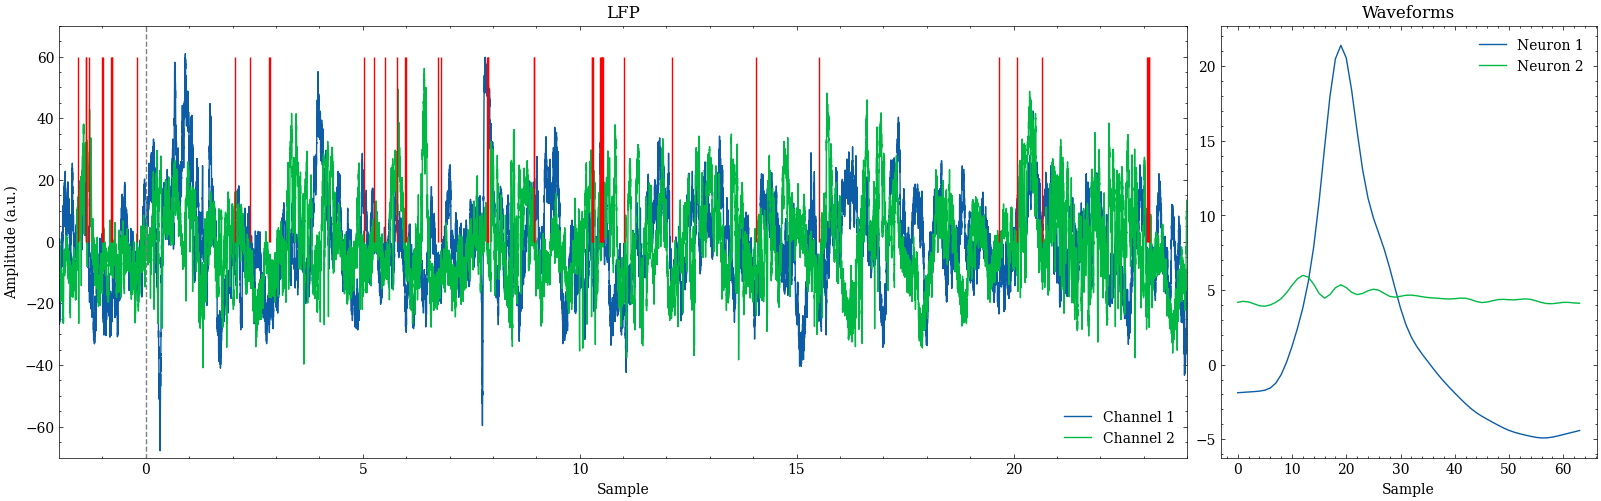

In [6]:
# Replace 'your_file.h5' with the actual path to your .h5 file
file_path = os.path.join(
    'data', 'amygdala', 'data_NIX', 'Data_Subject_01_Session_01.h5'
)

# Open the .h5 file in read mode
with h5py.File(file_path, 'r') as f:
    # Load the data
    times = f['data']['Data_Subject_01_Session_01']['data_arrays'][
        'Spike_Times_Unit_1_uAL_1_Trial_01'
    ]['data']
    lfp = f['data']['Data_Subject_01_Session_01']['data_arrays']['iEEG_Data_Trial_01'][
        'data'
    ]
    waveforms = f['data']['Data_Subject_01_Session_01']['data_arrays'][
        'Spike_Waveform_Unit_1_uAL_1'
    ]['data']

    # Convert the data to numpy arrays
    times = np.array(times)
    lfp = np.array(lfp)
    waveforms = np.array(waveforms)


# Plotting
axs = plt.figure(figsize=(16, 5), layout="constrained").subplot_mosaic(
    [[0, 0, 0, 1]],
)

x = np.linspace(-2, 24, lfp.shape[1])
axs[0].plot(x, lfp.T, label=['Channel 1', 'Channel 2'])
axs[0].vlines(0, -80, 80, color='grey', ls='--')
axs[0].vlines(times, 0, 60, color='r')
axs[1].plot(waveforms.T, label=['Neuron 1', 'Neuron 2'])

axs[0].legend(loc='lower right')
axs[1].legend()

axs[0].set_title('LFP')
axs[0].set_xlabel('Sample')
axs[0].set_ylabel('Amplitude (a.u.)')
axs[0].set_xlim([-2, 24])
axs[0].set_ylim([-70, 70])

axs[1].set_title('Waveforms')
axs[1].set_xlabel('Sample')
plt.show()